In [1]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange

from controllable_nca.dataset import MultiClass2DDataset
from controllable_nca.utils import load_emoji, rgb
import torch.nn.functional as F

class EmojiDataset(MultiClass2DDataset):
    # EMOJI = '🦎😀💥'
    EMOJI = "🦎"

    def __init__(self, image_size=48, padding=16):
        center = F.pad(
            torch.stack(
                [load_emoji(e, image_size) for e in EmojiDataset.EMOJI], dim=0
            ),
            (padding // 2, padding // 2, padding // 2, padding // 2, 0, 0)
        )
        left = F.pad(center, (0, padding, 0, 0, 0, 0, 0, 0))[:, :, :, padding:]
        right = F.pad(center, (padding, 0, 0, 0, 0, 0, 0, 0))[:, :, :, :-padding]
        emojis = torch.stack([center,left,right]).squeeze()
        self.padding = padding
        targets = torch.arange(emojis.size(0))
        super(EmojiDataset, self).__init__(emojis, targets, use_one_hot=True)

    def visualize(self, idx=0):
        self.plot_img(self.x[idx : idx + 1])

    def plot_img(self, img):
        with torch.no_grad():
            rgb_image = rgb(img, False).squeeze().detach().cpu().numpy()
        rgb_image = rearrange(rgb_image, "c w h -> w h c")
        _ = plt.imshow(rgb_image)
        plt.show()


In [2]:
dataset = EmojiDataset()

In [3]:
import torch.nn.functional as F

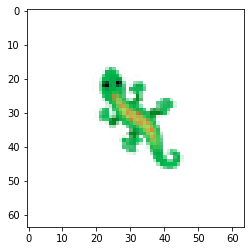

In [4]:
dataset.plot_img(dataset[0][0])

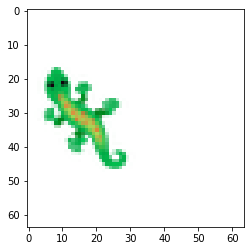

In [5]:
dataset.plot_img(dataset[1][0])

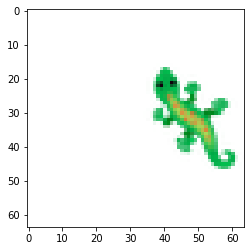

In [6]:
dataset.plot_img(dataset[2][0])

In [7]:
from controllable_nca.image.nca import ControllableImageNCA

In [8]:
from torch.nn import Embedding
import torch.nn as nn

In [9]:
class Encoder(nn.Module):
    def __init__(self, num_embeddings: int, out_channels: int, embedding_dim: int = 32):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = Embedding(num_embeddings, embedding_dim)
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64, out_channels, bias=False)
        )
    
    def forward(self, one_hot_encoding: torch.Tensor):
        indices = torch.argmax(one_hot_encoding, -1)
        embeddings = self.embedding(indices)
        return self.embedding_encoder(embeddings)

In [10]:
NUM_HIDDEN_CHANNELS = 8

encoder = Encoder(dataset.num_classes, NUM_HIDDEN_CHANNELS, 32)

In [11]:
nca =  ControllableImageNCA(target_shape=dataset.target_size(), encoder = encoder,living_channel_dim=3, num_hidden_channels=8)

In [12]:
nca.num_channels

13

In [13]:
device = torch.device('cuda')
dataset.to(device)
nca = nca.to(device)

In [14]:
from controllable_nca.image.trainer import ControllableNCAImageTrainer

In [15]:
trainer = ControllableNCAImageTrainer(nca, dataset, nca_steps=[48, 96], lr=1e-3, num_damaged=0, damage_radius=3, device=device, pool_size=256)

Writing to tensorboard_logs/2022-02-08 17:58:27.248792


In [16]:
trainer.train(batch_size=5, epochs=50000)

loss:0.010547536425292492--log10loss:-


KeyboardInterrupt: 